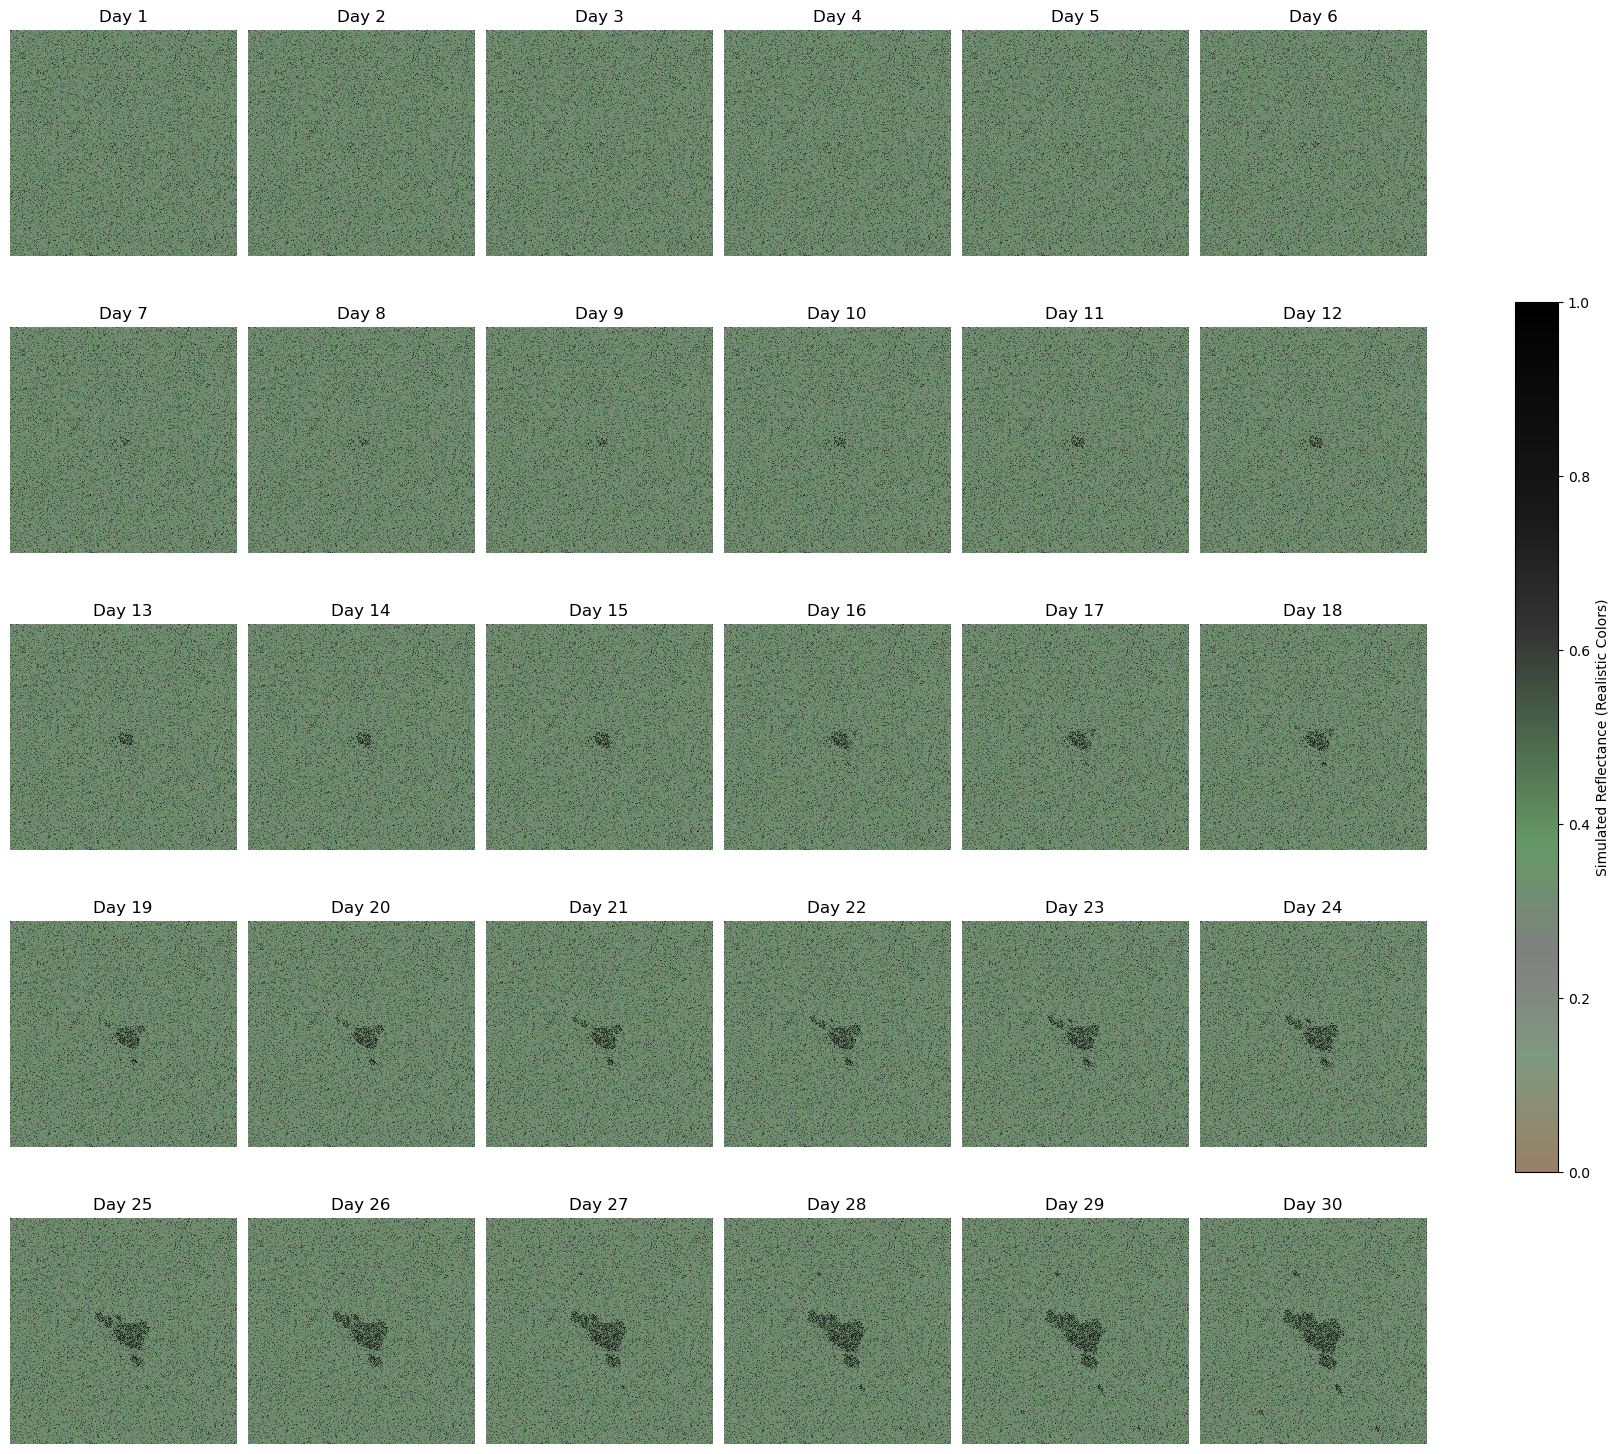

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import random

# Parameters
rows, cols = 256, 256
days = 30
burned_value_mean = 0.55
burned_value_std = 0.12
unburned_value_mean = 0.35
unburned_value_std = 0.12

# Initialize raster and fire mask
raster = np.random.normal(loc=unburned_value_mean, scale=unburned_value_std, size=(rows, cols))
raster = np.clip(raster, 0, 1)
burned_mask = np.zeros((rows, cols), dtype=bool)

# Initial ignition at center
center = (rows // 2, cols // 2)
burned_mask[center] = True
raster[center] = np.random.normal(loc=burned_value_mean, scale=burned_value_std)

# Wind bias (southeast)
wind_bias = (1, 1)
strong_wind_weight = 0.5
directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Time series stack
fire_history = []

for day in range(days):
    new_burns = set()
    fire_front = np.argwhere(burned_mask)
    current_extent = np.max(np.linalg.norm(fire_front - np.array(center), axis=1))

    for r, c in fire_front:
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols and not burned_mask[nr, nc]:
                prob = 0.1
                if (dr, dc) == wind_bias:
                    prob += strong_wind_weight
                elif (np.sign(dr), np.sign(dc)) == wind_bias:
                    prob += strong_wind_weight / 2
                if random.random() < prob:
                    new_burns.add((nr, nc))

    if random.random() < 0.3:
        unburned_candidates = np.argwhere(~burned_mask)
        jump_candidates = [
            (r, c) for r, c in unburned_candidates
            if np.min(np.linalg.norm(fire_front - np.array([r, c]), axis=1)) < current_extent
        ]
        if jump_candidates:
            nr, nc = random.choice(jump_candidates)
            new_burns.add((nr, nc))

    for r, c in new_burns:
        burned_mask[r, c] = True
        raster[r, c] = np.random.normal(loc=burned_value_mean, scale=burned_value_std)

    fire_history.append(np.copy(raster))

# Convert to NumPy time series array: shape (time, rows, cols)
fire_stack = np.stack(fire_history)

# Define realistic colormap: green/brown/gray background and black burned areas
background_colors = [
    (0.6, 0.5, 0.4),
    (0.5, 0.6, 0.5),
    (0.5, 0.5, 0.5),
    (0.4, 0.6, 0.4),
    (0.3, 0.4, 0.3)
]
burned_colors = [
    (0.2, 0.2, 0.2),
    (0.1, 0.1, 0.1),
    (0.05, 0.05, 0.05),
    (0.0, 0.0, 0.0)
]
full_palette = background_colors + burned_colors
realistic_fire_cmap = LinearSegmentedColormap.from_list("realistic_fire", full_palette, N=256)

# Optional: Plot the full time sequence
fig, axes = plt.subplots(5, 6, figsize=(18, 15))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(fire_stack[i], cmap=realistic_fire_cmap, interpolation='nearest', vmin=0, vmax=1)
    ax.set_title(f'Day {i+1}')
    ax.axis('off')

plt.tight_layout()
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label='Simulated Reflectance (Realistic Colors)')
plt.show()

# fire_stack is the output time-series array: shape = (30, 256, 256)


In [3]:
pip install ipywidgets matplotlib numpy


Note: you may need to restart the kernel to use updated packages.


In [5]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager


(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)


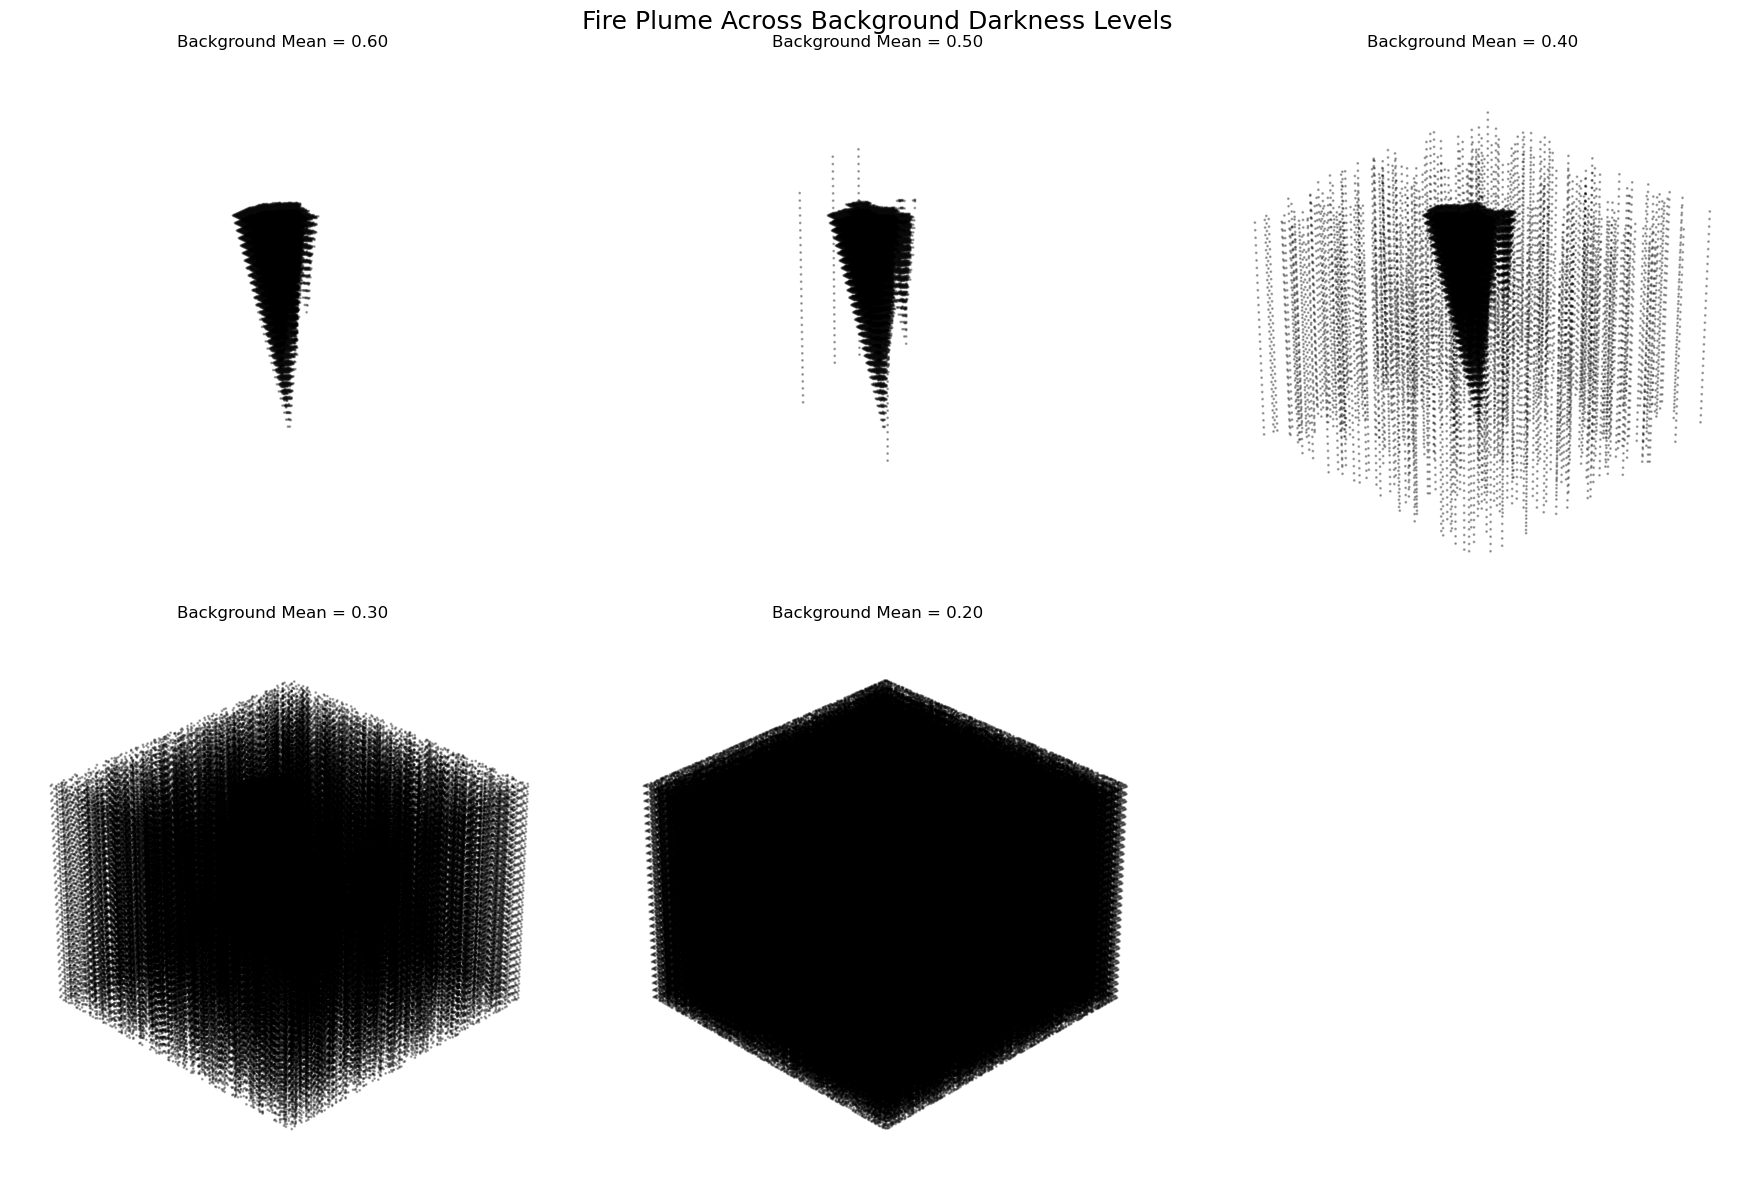

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# Constants
rows, cols = 256, 256
days = 30
wind_bias = (1, 1)
strong_wind_weight = 4.5
directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Function to simulate fire and extract 3D burned pixel plume
def generate_plume_fast(unburned_value_mean):
    unburned_value_std = 0.08
    burned_value_mean = 0.05
    burned_value_std = 0.05

    raster = np.random.normal(loc=unburned_value_mean, scale=unburned_value_std, size=(rows, cols))
    raster = np.clip(raster, 0, 1)
    burned_mask = np.zeros((rows, cols), dtype=bool)

    center = (rows // 2, cols // 2)
    burned_mask[center] = True
    raster[center] = np.random.normal(loc=burned_value_mean, scale=burned_value_std)

    fire_history = []

    for day in range(days):
        new_burns = set()
        fire_front = np.argwhere(burned_mask)
        current_extent = np.max(np.linalg.norm(fire_front - np.array(center), axis=1))

        for r, c in fire_front:
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and not burned_mask[nr, nc]:
                    prob = 0.1
                    if (dr, dc) == wind_bias:
                        prob += strong_wind_weight
                    elif (np.sign(dr), np.sign(dc)) == wind_bias:
                        prob += strong_wind_weight / 2
                    if random.random() < prob:
                        new_burns.add((nr, nc))

        if random.random() < 0.3:
            unburned_candidates = np.argwhere(~burned_mask)
            if len(unburned_candidates) > 0:
                sample_indices = np.random.choice(len(unburned_candidates), size=min(1000, len(unburned_candidates)), replace=False)
                sampled = unburned_candidates[sample_indices]
                distances = np.linalg.norm(sampled - center, axis=1)
                close_enough = sampled[distances < current_extent]
                if len(close_enough) > 0:
                    nr, nc = random.choice(close_enough)
                    new_burns.add((nr, nc))

        for r, c in new_burns:
            burned_mask[r, c] = True
            raster[r, c] = np.random.normal(loc=burned_value_mean, scale=burned_value_std)

        fire_history.append(np.copy(raster))

    fire_stack = np.stack(fire_history)
    burn_stack_mask = fire_stack < 0.2
    burn_coords = np.argwhere(burn_stack_mask)
    z, y, x = burn_coords[:, 0], burn_coords[:, 1], burn_coords[:, 2]

    return x, y, z

# Generate plume panel
background_means = [0.6, 0.5, 0.4, 0.3, 0.2]
n = len(background_means)
ncols = (n + 1) // 2
fig = plt.figure(figsize=(ncols * 6, 12))

for i, mean_val in enumerate(background_means):
    x, y, z = generate_plume_fast(mean_val)

    ax = fig.add_subplot(2, ncols, i + 1, projection='3d')
    ax.scatter(x, y, z, c='black', marker='o', alpha=0.3, s=1)
    ax.set_title(f'Background Mean = {mean_val:.2f}')
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_zlim(0, days)
    ax.axis('off')
    ax.view_init(elev=30, azim=135)

plt.suptitle("Fire Plume Across Background Darkness Levels", fontsize=18)
plt.tight_layout()
plt.show()


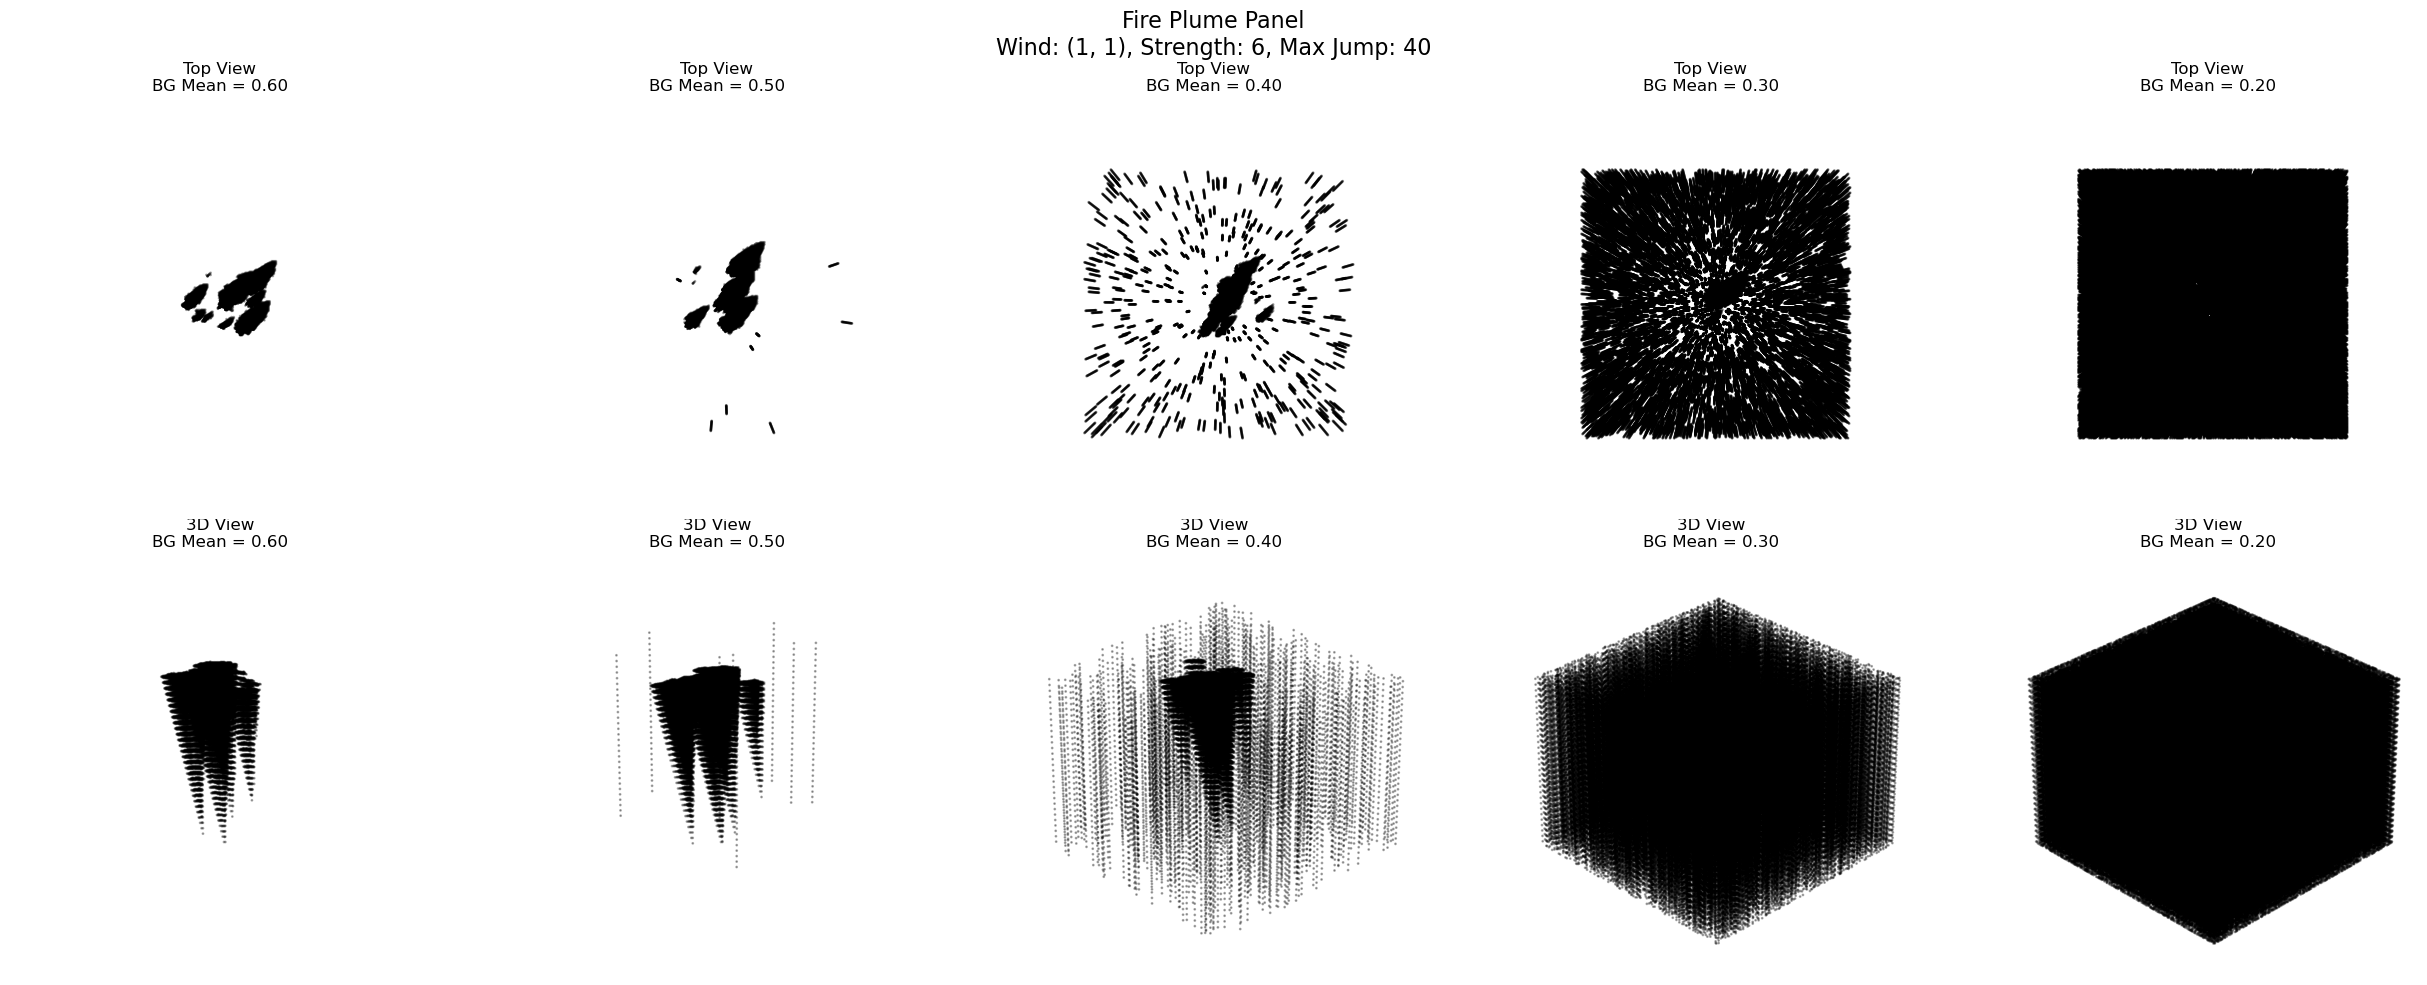

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# Constants
rows, cols = 256, 256
days = 30
directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
              (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Fire spread simulator
def generate_plume_with_wind_and_jumps(unburned_value_mean, wind_bias=(1, 1), wind_strength=0.6, max_jump_distance=20):
    unburned_value_std = 0.08
    burned_value_mean = 0.05
    burned_value_std = 0.05

    raster = np.random.normal(loc=unburned_value_mean, scale=unburned_value_std, size=(rows, cols))
    raster = np.clip(raster, 0, 1)
    burned_mask = np.zeros((rows, cols), dtype=bool)

    center = (rows // 2, cols // 2)
    burned_mask[center] = True
    raster[center] = np.random.normal(loc=burned_value_mean, scale=burned_value_std)

    fire_history = []

    for day in range(days):
        new_burns = set()
        fire_front = np.argwhere(burned_mask)

        for r, c in fire_front:
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and not burned_mask[nr, nc]:
                    prob = 0.05
                    if (dr, dc) == wind_bias:
                        prob += wind_strength
                    elif (np.sign(dr), np.sign(dc)) == wind_bias:
                        prob += wind_strength / 2
                    if random.random() < prob:
                        new_burns.add((nr, nc))

        if random.random() < 0.3:
            unburned_candidates = np.argwhere(~burned_mask)
            if len(unburned_candidates) > 0:
                sample_indices = np.random.choice(len(unburned_candidates), size=min(1000, len(unburned_candidates)), replace=False)
                sampled = unburned_candidates[sample_indices]
                distances = np.linalg.norm(sampled - center, axis=1)
                close_enough = sampled[distances < max_jump_distance]
                if len(close_enough) > 0:
                    nr, nc = random.choice(close_enough)
                    new_burns.add((nr, nc))

        for r, c in new_burns:
            burned_mask[r, c] = True
            raster[r, c] = np.random.normal(loc=burned_value_mean, scale=burned_value_std)

        fire_history.append(np.copy(raster))

    fire_stack = np.stack(fire_history)
    burn_stack_mask = fire_stack < 0.2
    burn_coords = np.argwhere(burn_stack_mask)
    z, y, x = burn_coords[:, 0], burn_coords[:, 1], burn_coords[:, 2]

    return x, y, z

# Panel plot with two views per background level
def plot_plume_panel(wind_bias=(1, 1), wind_strength=0.6, max_jump_distance=20):
    background_means = [0.6, 0.5, 0.4, 0.3, 0.2]
    n = len(background_means)
    fig = plt.figure(figsize=(n * 5, 10))

    for i, mean_val in enumerate(background_means):
        x, y, z = generate_plume_with_wind_and_jumps(
            mean_val,
            wind_bias=wind_bias,
            wind_strength=wind_strength,
            max_jump_distance=max_jump_distance
        )

        # 3D angled view (bottom row)
        ax_3d = fig.add_subplot(2, n, n + i + 1, projection='3d')
        ax_3d.scatter(x, y, z, c='black', marker='o', alpha=0.3, s=1)
        ax_3d.set_xlim(0, cols)
        ax_3d.set_ylim(0, rows)
        ax_3d.set_zlim(0, days)
        ax_3d.axis('off')
        ax_3d.set_title(f'3D View\nBG Mean = {mean_val:.2f}')
        ax_3d.view_init(elev=30, azim=135)

        # Top-down view (top row)
        ax_top = fig.add_subplot(2, n, i + 1, projection='3d')
        ax_top.scatter(x, y, z, c='black', marker='o', alpha=0.3, s=1)
        ax_top.set_xlim(0, cols)
        ax_top.set_ylim(0, rows)
        ax_top.set_zlim(0, days)
        ax_top.axis('off')
        ax_top.set_title(f'Top View\nBG Mean = {mean_val:.2f}')
        ax_top.view_init(elev=90, azim=-90)

    plt.suptitle(
        f"Fire Plume Panel\nWind: {wind_bias}, Strength: {wind_strength}, Max Jump: {max_jump_distance}",
        fontsize=16
    )
    plt.tight_layout()
    plt.show()

# Run it!
plot_plume_panel(wind_bias=(1, 1), wind_strength=6, max_jump_distance=40)


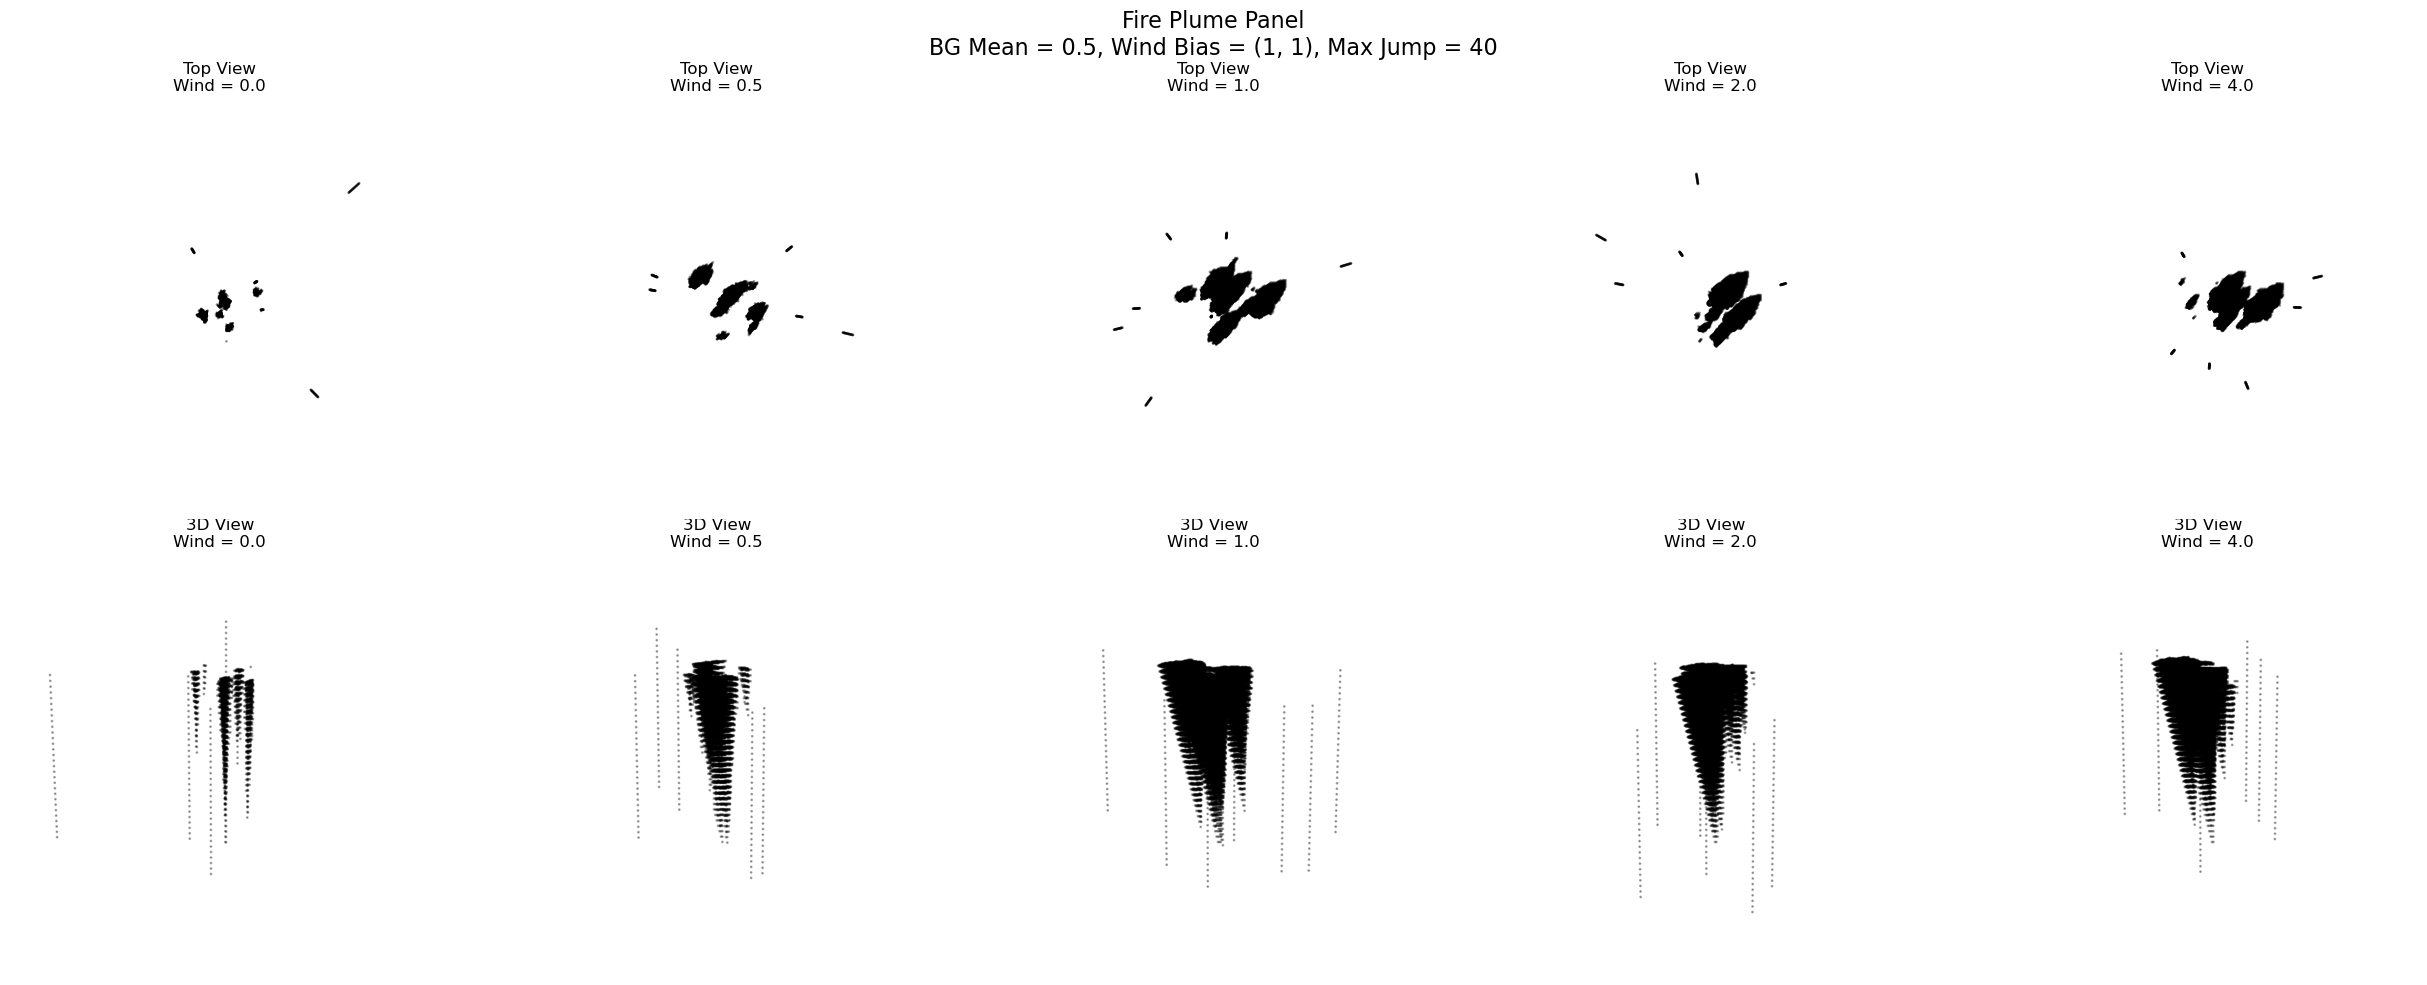

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# Constants
rows, cols = 256, 256
days = 30
directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
              (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Fire spread simulator
def generate_plume_with_wind_and_jumps(unburned_value_mean, wind_bias=(1, 1), wind_strength=0.6, max_jump_distance=20):
    unburned_value_std = 0.08
    burned_value_mean = 0.05
    burned_value_std = 0.05

    raster = np.random.normal(loc=unburned_value_mean, scale=unburned_value_std, size=(rows, cols))
    raster = np.clip(raster, 0, 1)
    burned_mask = np.zeros((rows, cols), dtype=bool)

    center = (rows // 2, cols // 2)
    burned_mask[center] = True
    raster[center] = np.random.normal(loc=burned_value_mean, scale=burned_value_std)

    fire_history = []

    for day in range(days):
        new_burns = set()
        fire_front = np.argwhere(burned_mask)

        for r, c in fire_front:
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and not burned_mask[nr, nc]:
                    prob = 0.05
                    if (dr, dc) == wind_bias:
                        prob += wind_strength
                    elif (np.sign(dr), np.sign(dc)) == wind_bias:
                        prob += wind_strength / 2
                    if random.random() < prob:
                        new_burns.add((nr, nc))

        if random.random() < 0.3:
            unburned_candidates = np.argwhere(~burned_mask)
            if len(unburned_candidates) > 0:
                sample_indices = np.random.choice(len(unburned_candidates), size=min(1000, len(unburned_candidates)), replace=False)
                sampled = unburned_candidates[sample_indices]
                distances = np.linalg.norm(sampled - center, axis=1)
                close_enough = sampled[distances < max_jump_distance]
                if len(close_enough) > 0:
                    nr, nc = random.choice(close_enough)
                    new_burns.add((nr, nc))

        for r, c in new_burns:
            burned_mask[r, c] = True
            raster[r, c] = np.random.normal(loc=burned_value_mean, scale=burned_value_std)

        fire_history.append(np.copy(raster))

    fire_stack = np.stack(fire_history)
    burn_stack_mask = fire_stack < 0.2
    burn_coords = np.argwhere(burn_stack_mask)
    z, y, x = burn_coords[:, 0], burn_coords[:, 1], burn_coords[:, 2]

    return x, y, z

# Panel plot showing varying wind strengths
def plot_plume_panel_varying_wind(wind_bias=(1, 1), wind_strengths=[0.0, 0.5, 1.0, 2.0, 4.0], max_jump_distance=20):
    unburned_value_mean = 0.5
    n = len(wind_strengths)
    fig = plt.figure(figsize=(n * 5, 10))

    for i, strength in enumerate(wind_strengths):
        x, y, z = generate_plume_with_wind_and_jumps(
            unburned_value_mean,
            wind_bias=wind_bias,
            wind_strength=strength,
            max_jump_distance=max_jump_distance
        )

        # 3D angled view
        ax_3d = fig.add_subplot(2, n, n + i + 1, projection='3d')
        ax_3d.scatter(x, y, z, c='black', marker='o', alpha=0.3, s=1)
        ax_3d.set_xlim(0, cols)
        ax_3d.set_ylim(0, rows)
        ax_3d.set_zlim(0, days)
        ax_3d.axis('off')
        ax_3d.set_title(f'3D View\nWind = {strength}')
        ax_3d.view_init(elev=30, azim=135)

        # Top-down view
        ax_top = fig.add_subplot(2, n, i + 1, projection='3d')
        ax_top.scatter(x, y, z, c='black', marker='o', alpha=0.3, s=1)
        ax_top.set_xlim(0, cols)
        ax_top.set_ylim(0, rows)
        ax_top.set_zlim(0, days)
        ax_top.axis('off')
        ax_top.set_title(f'Top View\nWind = {strength}')
        ax_top.view_init(elev=90, azim=-90)

    plt.suptitle(
        f"Fire Plume Panel\nBG Mean = 0.5, Wind Bias = {wind_bias}, Max Jump = {max_jump_distance}",
        fontsize=16
    )
    plt.tight_layout()
    plt.show()

# Run it with varying wind strength
plot_plume_panel_varying_wind(
    wind_bias=(1, 1),
    wind_strengths=[0.0, 0.5, 1.0, 2.0, 4.0],
    max_jump_distance=40
)


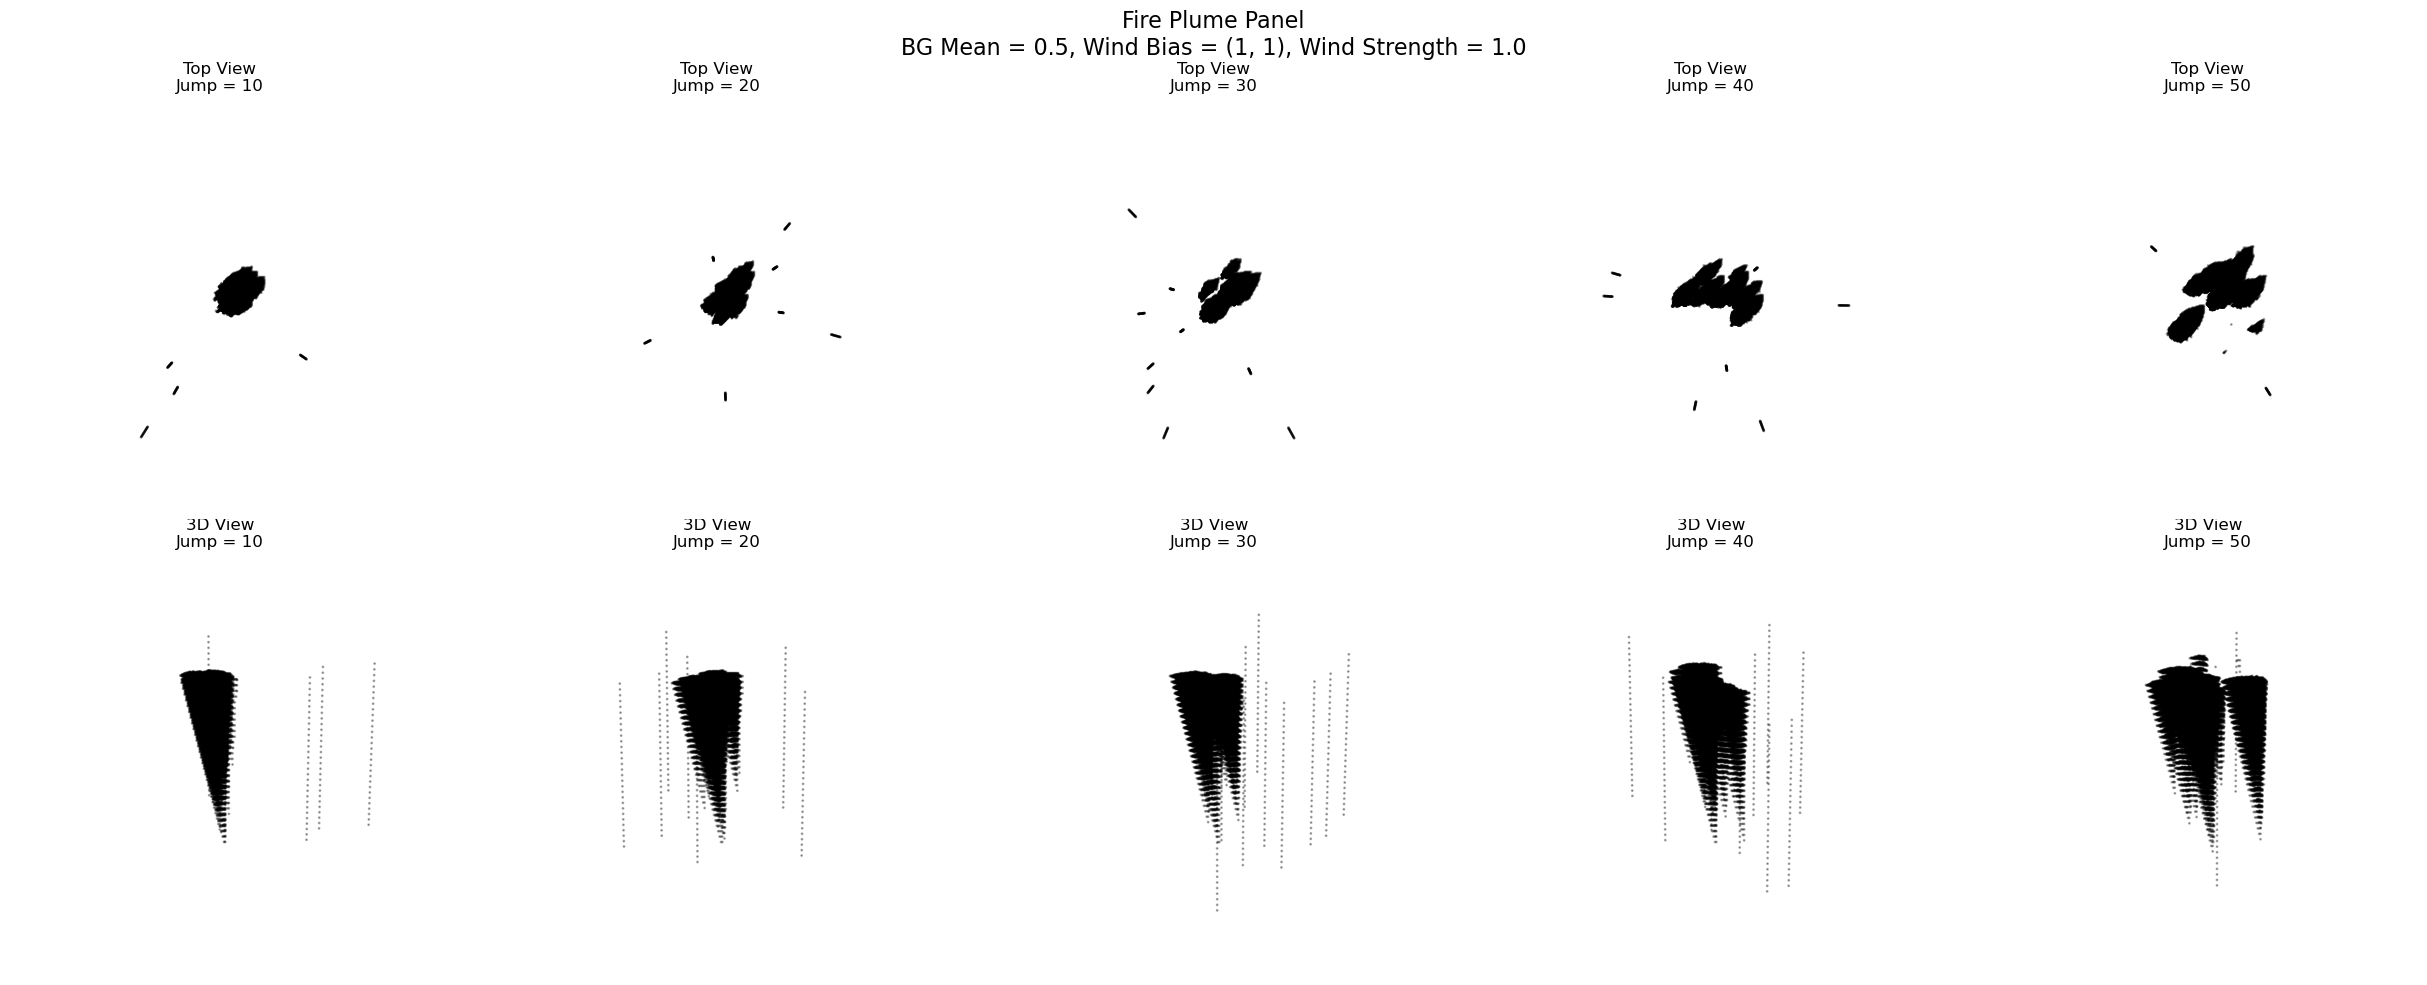

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# Constants
rows, cols = 256, 256
days = 30
directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
              (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Fire spread simulator
def generate_plume_with_wind_and_jumps(unburned_value_mean, wind_bias=(1, 1), wind_strength=0.6, max_jump_distance=20):
    unburned_value_std = 0.08
    burned_value_mean = 0.05
    burned_value_std = 0.05

    raster = np.random.normal(loc=unburned_value_mean, scale=unburned_value_std, size=(rows, cols))
    raster = np.clip(raster, 0, 1)
    burned_mask = np.zeros((rows, cols), dtype=bool)

    center = (rows // 2, cols // 2)
    burned_mask[center] = True
    raster[center] = np.random.normal(loc=burned_value_mean, scale=burned_value_std)

    fire_history = []

    for day in range(days):
        new_burns = set()
        fire_front = np.argwhere(burned_mask)

        for r, c in fire_front:
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and not burned_mask[nr, nc]:
                    prob = 0.05
                    if (dr, dc) == wind_bias:
                        prob += wind_strength
                    elif (np.sign(dr), np.sign(dc)) == wind_bias:
                        prob += wind_strength / 2
                    if random.random() < prob:
                        new_burns.add((nr, nc))

        if random.random() < 0.3:
            unburned_candidates = np.argwhere(~burned_mask)
            if len(unburned_candidates) > 0:
                sample_indices = np.random.choice(len(unburned_candidates), size=min(1000, len(unburned_candidates)), replace=False)
                sampled = unburned_candidates[sample_indices]
                distances = np.linalg.norm(sampled - center, axis=1)
                close_enough = sampled[distances < max_jump_distance]
                if len(close_enough) > 0:
                    nr, nc = random.choice(close_enough)
                    new_burns.add((nr, nc))

        for r, c in new_burns:
            burned_mask[r, c] = True
            raster[r, c] = np.random.normal(loc=burned_value_mean, scale=burned_value_std)

        fire_history.append(np.copy(raster))

    fire_stack = np.stack(fire_history)
    burn_stack_mask = fire_stack < 0.2
    burn_coords = np.argwhere(burn_stack_mask)
    z, y, x = burn_coords[:, 0], burn_coords[:, 1], burn_coords[:, 2]

    return x, y, z

# Panel plot showing varying jump distances
def plot_plume_panel_varying_jump(wind_bias=(1, 1), wind_strength=0.6, jump_distances=[0, 5, 10, 20, 40]):
    unburned_value_mean = 0.5
    n = len(jump_distances)
    fig = plt.figure(figsize=(n * 5, 10))

    for i, jump in enumerate(jump_distances):
        x, y, z = generate_plume_with_wind_and_jumps(
            unburned_value_mean,
            wind_bias=wind_bias,
            wind_strength=wind_strength,
            max_jump_distance=jump
        )

        # 3D angled view
        ax_3d = fig.add_subplot(2, n, n + i + 1, projection='3d')
        ax_3d.scatter(x, y, z, c='black', marker='o', alpha=0.3, s=1)
        ax_3d.set_xlim(0, cols)
        ax_3d.set_ylim(0, rows)
        ax_3d.set_zlim(0, days)
        ax_3d.axis('off')
        ax_3d.set_title(f'3D View\nJump = {jump}')
        ax_3d.view_init(elev=30, azim=135)

        # Top-down view
        ax_top = fig.add_subplot(2, n, i + 1, projection='3d')
        ax_top.scatter(x, y, z, c='black', marker='o', alpha=0.3, s=1)
        ax_top.set_xlim(0, cols)
        ax_top.set_ylim(0, rows)
        ax_top.set_zlim(0, days)
        ax_top.axis('off')
        ax_top.set_title(f'Top View\nJump = {jump}')
        ax_top.view_init(elev=90, azim=-90)

    plt.suptitle(
        f"Fire Plume Panel\nBG Mean = 0.5, Wind Bias = {wind_bias}, Wind Strength = {wind_strength}",
        fontsize=16
    )
    plt.tight_layout()
    plt.show()

# Run it with varying jump distances
plot_plume_panel_varying_jump(
    wind_bias=(1, 1),
    wind_strength=1.0,
    jump_distances=[10, 20, 30, 40, 50]
)


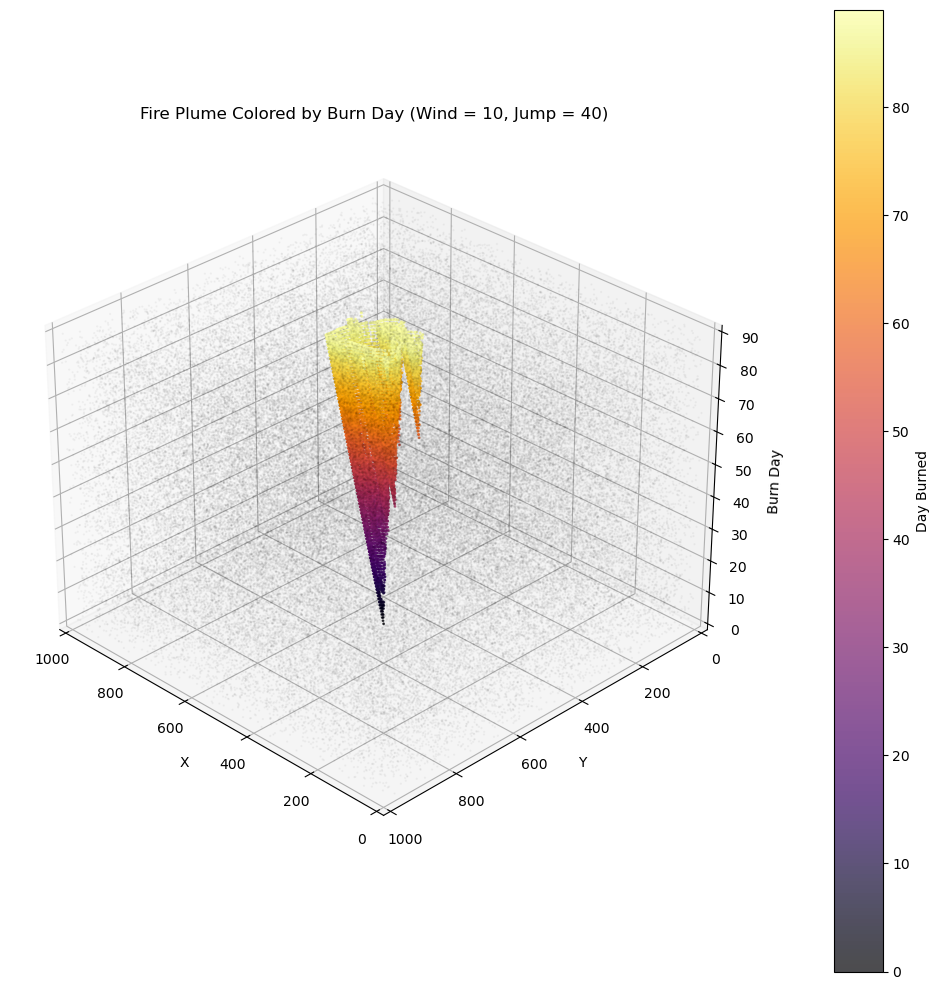

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# Constants
rows, cols = 1000, 1000
days = 90
directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
              (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Fire spread simulator with burn day tracking
def generate_burn_day_plume(unburned_value_mean=0.5, wind_bias=(1, 1), wind_strength=10.0, max_jump_distance=40):
    unburned_value_std = 0.08
    burned_value_mean = 0.05
    burned_value_std = 0.05

    raster = np.random.normal(unburned_value_mean, unburned_value_std, size=(rows, cols))
    raster = np.clip(raster, 0, 1)
    burned_mask = np.zeros((rows, cols), dtype=bool)
    burn_day = np.full((rows, cols), fill_value=-1, dtype=int)

    center = (rows // 2, cols // 2)
    burned_mask[center] = True
    burn_day[center] = 0
    raster[center] = np.random.normal(burned_value_mean, burned_value_std)

    for day in range(1, days):
        new_burns = set()
        fire_front = np.argwhere(burned_mask)

        for r, c in fire_front:
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and not burned_mask[nr, nc]:
                    prob = 0.05
                    if (dr, dc) == wind_bias:
                        prob += wind_strength
                    elif (np.sign(dr), np.sign(dc)) == wind_bias:
                        prob += wind_strength / 2
                    if random.random() < prob:
                        new_burns.add((nr, nc))

        if random.random() < 0.3:
            unburned_candidates = np.argwhere(~burned_mask)
            if len(unburned_candidates) > 0:
                sample_indices = np.random.choice(len(unburned_candidates), size=min(1000, len(unburned_candidates)), replace=False)
                sampled = unburned_candidates[sample_indices]
                distances = np.linalg.norm(sampled - center, axis=1)
                current_extent = np.max(np.linalg.norm(fire_front - center, axis=1))
                close_enough = sampled[distances < current_extent]
                if len(close_enough) > 0:
                    nr, nc = random.choice(close_enough)
                    new_burns.add((nr, nc))

        for r, c in new_burns:
            burned_mask[r, c] = True
            burn_day[r, c] = day
            raster[r, c] = np.random.normal(burned_value_mean, burned_value_std)

    return burn_day, burned_mask

# Plot with both burn color and black background points
def plot_burn_plume_with_background():
    burn_day, burned_mask = generate_burn_day_plume()

    # Burned pixels
    burned_coords = np.argwhere(burn_day >= 0)
    burn_z = burn_day[burn_day >= 0]
    burn_y, burn_x = burned_coords[:, 0], burned_coords[:, 1]

    # Background (unburned) points – sparse random sample
    unburned_mask = ~burned_mask
    bg_coords = np.argwhere(unburned_mask)
    bg_sample_indices = np.random.choice(len(bg_coords), size=100000, replace=False)
    bg_sample = bg_coords[bg_sample_indices]
    bg_y, bg_x = bg_sample[:, 0], bg_sample[:, 1]
    bg_z = np.random.randint(0, days, size=bg_sample.shape[0])

    # Plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Background (faint black)
    ax.scatter(bg_x, bg_y, bg_z, c='black', alpha=0.03, s=0.5)

    # Fire plume (colored by burn day)
    sc = ax.scatter(burn_x, burn_y, burn_z, c=burn_z, cmap='inferno', alpha=0.7, s=1)

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_zlim(0, days)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Burn Day")
    ax.set_title("Fire Plume Colored by Burn Day (Wind = 10, Jump = 40)")
    ax.view_init(elev=30, azim=135)

    cbar = plt.colorbar(sc, ax=ax, pad=0.1)
    cbar.set_label("Day Burned")

    plt.tight_layout()
    plt.savefig("fire_plume_with_black_background.png", dpi=300)
    plt.show()

# Run it
plot_burn_plume_with_background()


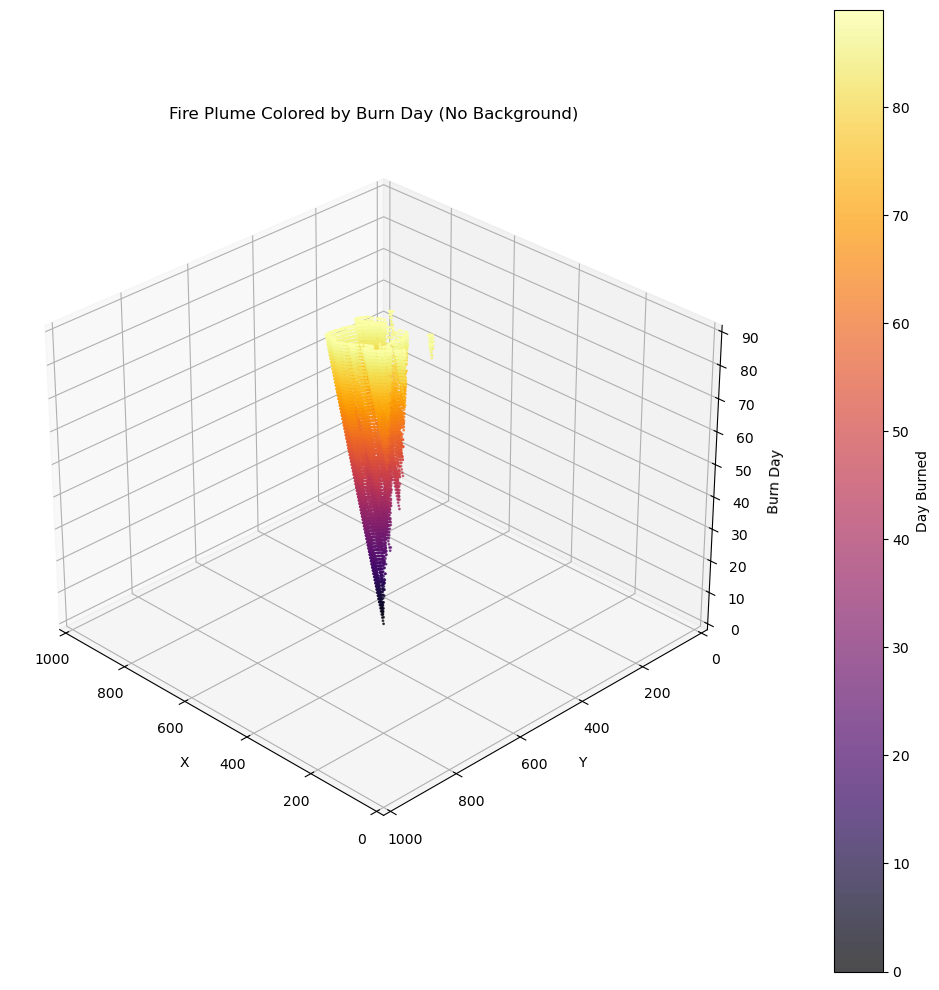

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# Constants
rows, cols = 1000, 1000
days = 90
directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
              (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Fire simulation with burn day tracking
def generate_burn_day_plume(unburned_value_mean=0.5, wind_bias=(1, 1), wind_strength=10.0, max_jump_distance=40):
    unburned_value_std = 0.08
    burned_value_mean = 0.05
    burned_value_std = 0.05

    raster = np.random.normal(unburned_value_mean, unburned_value_std, size=(rows, cols))
    raster = np.clip(raster, 0, 1)
    burned_mask = np.zeros((rows, cols), dtype=bool)
    burn_day = np.full((rows, cols), fill_value=-1, dtype=int)

    center = (rows // 2, cols // 2)
    burned_mask[center] = True
    burn_day[center] = 0
    raster[center] = np.random.normal(burned_value_mean, burned_value_std)

    for day in range(1, days):
        new_burns = set()
        fire_front = np.argwhere(burned_mask)

        for r, c in fire_front:
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and not burned_mask[nr, nc]:
                    prob = 0.05
                    if (dr, dc) == wind_bias:
                        prob += wind_strength
                    elif (np.sign(dr), np.sign(dc)) == wind_bias:
                        prob += wind_strength / 2
                    if random.random() < prob:
                        new_burns.add((nr, nc))

        if random.random() < 0.3:
            unburned_candidates = np.argwhere(~burned_mask)
            if len(unburned_candidates) > 0:
                sample_indices = np.random.choice(len(unburned_candidates), size=min(1000, len(unburned_candidates)), replace=False)
                sampled = unburned_candidates[sample_indices]
                distances = np.linalg.norm(sampled - center, axis=1)
                current_extent = np.max(np.linalg.norm(fire_front - center, axis=1))
                close_enough = sampled[distances < current_extent]
                if len(close_enough) > 0:
                    nr, nc = random.choice(close_enough)
                    new_burns.add((nr, nc))

        for r, c in new_burns:
            burned_mask[r, c] = True
            burn_day[r, c] = day
            raster[r, c] = np.random.normal(burned_value_mean, burned_value_std)

    return burn_day

# Plot only burned pixels colored by burn day
def plot_burn_plume_clean():
    burn_day = generate_burn_day_plume()

    # Extract burned pixel coordinates and burn times
    burned_coords = np.argwhere(burn_day >= 0)
    z = burn_day[burn_day >= 0]
    y, x = burned_coords[:, 0], burned_coords[:, 1]

    # Plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x, y, z, c=z, cmap='inferno', alpha=0.7, s=1)

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_zlim(0, days)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Burn Day")
    ax.set_title("Fire Plume Colored by Burn Day (No Background)")
    ax.view_init(elev=30, azim=135)

    cbar = plt.colorbar(sc, ax=ax, pad=0.1)
    cbar.set_label("Day Burned")

    plt.tight_layout()
    plt.savefig("fire_plume_burned_only.png", dpi=300)
    plt.show()

# Run it
plot_burn_plume_clean()


In [48]:
import numpy as np
import pandas as pd
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import random
import geopandas as gpd

# ─── 1) FIRE SIMULATION ─────────────────────────────────────────────────────────

def simulate_burn_day(rows, cols, days,
                      wind_bias=(1,1),
                      wind_strength=1.0,
                      max_jump_distance=20):
    """
    Simulate burn-day grid: each pixel stores the day it burned (0…days-1),
    or -1 if never burned.
    """
    directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    burn_day = np.full((rows, cols), -1, dtype=int)
    burned = np.zeros((rows, cols), bool)

    # ignite center
    center = (rows//2, cols//2)
    burned[center] = True
    burn_day[center] = 0

    for day in range(1, days):
        new = set()
        front = np.argwhere(burned)
        # neighbor spread
        for r, c in front:
            for dr, dc in directions:
                nr, nc = r+dr, c+dc
                if 0 <= nr < rows and 0 <= nc < cols and not burned[nr, nc]:
                    p = 0.05
                    if (dr, dc) == wind_bias:
                        p += wind_strength
                    elif (np.sign(dr), np.sign(dc)) == wind_bias:
                        p += wind_strength / 2
                    if random.random() < p:
                        new.add((nr, nc))
        # spotting
        if random.random() < 0.3 and front.size > 0:
            cand = np.argwhere(~burned)
            if cand.size > 0:
                samp = cand[np.random.choice(len(cand), min(1000, len(cand)), replace=False)]
                dists = np.linalg.norm(samp - center, axis=1)
                extent = np.max(np.linalg.norm(front - center, axis=1))
                close = samp[dists < extent]
                if close.size > 0:
                    nr, nc = tuple(close[random.randrange(len(close))])
                    new.add((nr, nc))
        # apply burns
        for (r, c) in new:
            burned[r, c] = True
            burn_day[r, c] = day

    return burn_day

# ─── 2) POLYGON STATS & FITTING ─────────────────────────────────────────────────

def polygon_stats(geom):
    """Return (origins, total_area, total_perimeter)."""
    if isinstance(geom, Polygon):
        return 1, geom.area, geom.length
    if isinstance(geom, MultiPolygon):
        return len(geom.geoms), sum(p.area for p in geom.geoms), sum(p.length for p in geom.geoms)
    return 0, 0.0, 0.0

def fit_polygons_from_masks(masks):
    """Contour each mask, skip short contours, union all polygons."""
    rows = masks[0].shape[0]
    polys = []
    for m in masks:
        for contour in measure.find_contours(m.astype(float), 0.5):
            if contour.shape[0] < 4:
                continue
            coords = [(p[1], rows - p[0]) for p in contour]
            try:
                poly = Polygon(coords)
            except ValueError:
                continue
            if poly.is_valid and poly.area > 1:
                polys.append(poly)
    return unary_union(polys)

def fit_polygons(burn_day, method="bottom_up", noise_per_day=0):
    """
    method="bottom_up": build daily masks, inject noise_per_day spurious pixels, union
    method="top_down": contour only the final mask
    """
    rows, cols = burn_day.shape
    final_mask = (burn_day >= 0)

    if method == "bottom_up":
        masks = []
        for d in range(burn_day.max() + 1):
            m = (burn_day == d).copy()
            if noise_per_day > 0:
                coords = np.unravel_index(
                    np.random.choice(rows * cols, noise_per_day, replace=False),
                    (rows, cols)
                )
                m[coords] = True
            masks.append(m)
        unioned = fit_polygons_from_masks(masks)
    else:  # top_down
        unioned = fit_polygons_from_masks([final_mask])

    origins, area, perim = polygon_stats(unioned)
    return unioned, origins, area, perim

# ─── 3) PARAMETER SWEEP ─────────────────────────────────────────────────────────

def run_sweep(rows=256, cols=256,
              days_list=[30,60,90],
              wind_strengths=[0.5,1.0,2.0],
              jump_distances=[0,10,20],
              noise_per_day=50):
    records = []
    for days in days_list:
        for w in wind_strengths:
            for j in jump_distances:
                bd = simulate_burn_day(rows, cols, days,
                                       wind_strength=w,
                                       max_jump_distance=j)
                # real polygon (true final mask)
                _, real_orig, real_area, real_perim = fit_polygons(
                    bd, method="top_down", noise_per_day=0
                )
                # top-down inference
                _, td_orig, td_area, td_perim = fit_polygons(
                    bd, method="top_down", noise_per_day=0
                )
                # bottom-up inference with noise
                _, bu_orig, bu_area, bu_perim = fit_polygons(
                    bd, method="bottom_up", noise_per_day=noise_per_day
                )

                records.append({
                    "days": days,
                    "wind_strength": w,
                    "max_jump_dist": j,
                    "noise_per_day": noise_per_day,
                    "real_origins": real_orig,
                    "td_origins": td_orig,
                    "bu_origins": bu_orig,
                    "real_area": real_area,
                    "td_area": td_area,
                    "bu_area": bu_area,
                    "real_perimeter": real_perim,
                    "td_perimeter": td_perim,
                    "bu_perimeter": bu_perim
                })
    return pd.DataFrame(records)

# ─── 4) EXECUTE & SAVE ──────────────────────────────────────────────────────────

if __name__ == "__main__":
    df = run_sweep(
        rows=256, cols=256,
        days_list=[30,60,90],
        wind_strengths=[0.5,1.0,2.0],
        jump_distances=[0,10,20],
        noise_per_day=50
    )

    # Print summary of origin counts
    pd.set_option("display.width", None)
    print(df[["real_origins","td_origins","bu_origins"]].describe())

    # Save full table
    df.to_csv("polygon_comparison_sweep_with_noise.csv", index=False)
    print("Saved to polygon_comparison_sweep_with_noise.csv")


       real_origins  td_origins   bu_origins
count     27.000000   27.000000    27.000000
mean       5.518519    5.518519   801.222222
std        2.577571    2.577571   687.974079
min        1.000000    1.000000    50.000000
25%        4.000000    4.000000   174.500000
50%        5.000000    5.000000   576.000000
75%        7.000000    7.000000  1303.000000
max       11.000000   11.000000  2283.000000
Saved to polygon_comparison_sweep_with_noise.csv


In [50]:
# Group by wind_strength
print(df.groupby("wind_strength")[["real_origins","td_origins","bu_origins"]]
        .describe().unstack(1))

# Group by max_jump_dist
print(df.groupby("max_jump_dist")[["real_origins","td_origins","bu_origins"]]
        .describe().unstack(1))

# Group by days
print(df.groupby("days")[["real_origins","td_origins","bu_origins"]]
        .describe().unstack(1))


                     wind_strength
real_origins  count  0.5                 9.000000
                     1.0                 9.000000
                     2.0                 9.000000
              mean   0.5                 5.333333
                     1.0                 6.111111
                     2.0                 5.111111
              std    0.5                 2.828427
                     1.0                 2.666667
                     2.0                 2.420973
              min    0.5                 2.000000
                     1.0                 1.000000
                     2.0                 3.000000
              25%    0.5                 4.000000
                     1.0                 5.000000
                     2.0                 3.000000
              50%    0.5                 5.000000
                     1.0                 6.000000
                     2.0                 4.000000
              75%    0.5                 7.000000
               

Results saved to improved_bottomup_sweep.csv


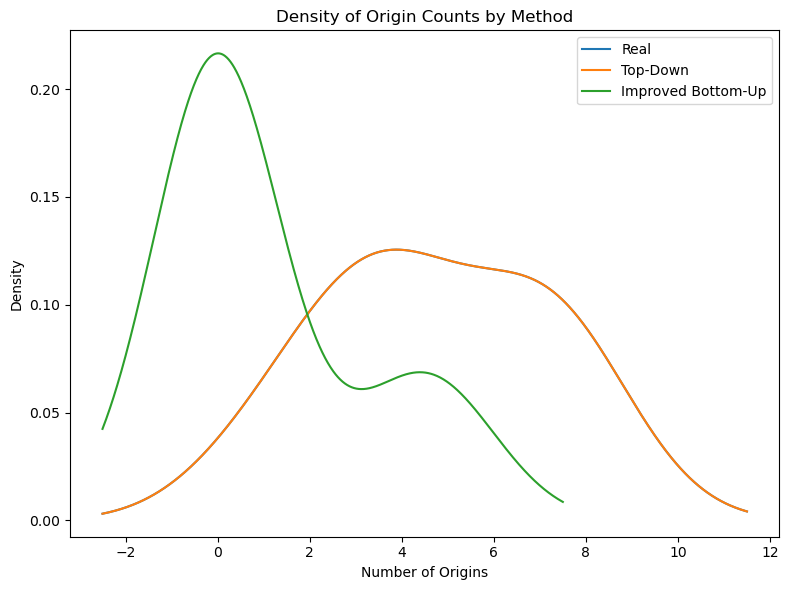


Real vs Top-Down:
  KS test   → statistic=0.000, p-value=1.000
  MW U test → statistic=32.0, p-value=1.000

Real vs Improved BU:
  KS test   → statistic=0.750, p-value=0.019
  MW U test → statistic=56.0, p-value=0.011

TD vs Improved BU:
  KS test   → statistic=0.750, p-value=0.019
  MW U test → statistic=56.0, p-value=0.011


In [55]:
import numpy as np
import pandas as pd
import random
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from scipy.ndimage import label
from scipy.stats import ks_2samp, mannwhitneyu
import matplotlib.pyplot as plt

# ─── 1) FIRE SIMULATION ─────────────────────────────────────────────────────────

def simulate_burn_day(rows, cols, days,
                      wind_bias=(1,1),
                      wind_strength=1.0,
                      max_jump_distance=20):
    directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    burn_day = np.full((rows, cols), -1, dtype=int)
    burned   = np.zeros((rows, cols), bool)
    center = (rows//2, cols//2)
    burned[center]   = True
    burn_day[center] = 0

    for day in range(1, days):
        new = set()
        front = np.argwhere(burned)
        # neighbor spread
        for r,c in front:
            for dr,dc in directions:
                nr,nc = r+dr, c+dc
                if 0<=nr<rows and 0<=nc<cols and not burned[nr,nc]:
                    p = 0.05
                    if (dr,dc)==wind_bias:
                        p += wind_strength
                    elif (np.sign(dr),np.sign(dc))==wind_bias:
                        p += wind_strength/2
                    if random.random()<p:
                        new.add((nr,nc))
        # spotting
        if random.random()<0.3 and front.size>0:
            cand = np.argwhere(~burned)
            if cand.size>0:
                samp = cand[np.random.choice(len(cand),
                                             min(1000,len(cand)),
                                             replace=False)]
                dists  = np.linalg.norm(samp-center,axis=1)
                extent = np.max(np.linalg.norm(front-center,axis=1))
                close  = samp[dists<extent]
                if close.size>0:
                    nr,nc = tuple(close[random.randrange(len(close))])
                    new.add((nr,nc))
        # apply
        for (r,c) in new:
            burned[r,c]   = True
            burn_day[r,c] = day

    return burn_day

# ─── 2) CLUSTER FILTER ──────────────────────────────────────────────────────────

def filter_small_clusters(mask, min_size):
    lbl, n = label(mask)
    out = np.zeros_like(mask)
    for comp in range(1, n+1):
        comp_mask = (lbl==comp)
        if comp_mask.sum() >= min_size:
            out[comp_mask] = True
    return out

# ─── 3) POLYGON FITTING & STATS ────────────────────────────────────────────────

def polygon_stats(geom):
    if isinstance(geom, Polygon):
        return 1, geom.area, geom.length
    if isinstance(geom, MultiPolygon):
        return (len(geom.geoms),
                sum(p.area   for p in geom.geoms),
                sum(p.length for p in geom.geoms))
    return 0, 0.0, 0.0

def fit_polygons_from_masks(masks):
    rows = masks[0].shape[0]
    polys = []
    for m in masks:
        for contour in measure.find_contours(m.astype(float), 0.5):
            if contour.shape[0] < 4:
                continue
            coords = [(p[1], rows - p[0]) for p in contour]
            poly = Polygon(coords)
            if poly.is_valid and poly.area > 1:
                polys.append(poly)
    return unary_union(polys)

def fit_polygons_top_down(burn_day):
    final = (burn_day >= 0)
    unioned = fit_polygons_from_masks([final])
    return polygon_stats(unioned)

def fit_polygons_bottom_up_improved(burn_day,
                                   noise_per_day=50,
                                   min_cluster_size=10):
    rows, cols = burn_day.shape
    masks = []
    for d in range(burn_day.max()+1):
        m = (burn_day == d).copy()
        # inject noise
        coords = np.unravel_index(
            np.random.choice(rows*cols, noise_per_day, replace=False),
            (rows, cols)
        )
        m[coords] = True
        # filter clusters
        m = filter_small_clusters(m, min_cluster_size)
        masks.append(m)
    unioned = fit_polygons_from_masks(masks)
    return polygon_stats(unioned)

# ─── 4) SWEEP, DENSITY PLOT & STATS ─────────────────────────────────────────────

def run_sweep_and_analyze(rows=256, cols=256,
                          days_list=[30,60],
                          wind_strengths=[0.5,1.0],
                          jump_distances=[0,10],
                          noise_per_day=50,
                          min_cluster_size=10):
    records = []
    for days in days_list:
        for w in wind_strengths:
            for j in jump_distances:
                bd = simulate_burn_day(rows, cols, days,
                                       wind_strength=w,
                                       max_jump_distance=j)
                real_o, *_  = fit_polygons_top_down(bd)
                td_o,   *_  = fit_polygons_top_down(bd)
                bu2_o,  *_  = fit_polygons_bottom_up_improved(
                                  bd,
                                  noise_per_day=noise_per_day,
                                  min_cluster_size=min_cluster_size)

                records.append({
                    "real_origins": real_o,
                    "td_origins":   td_o,
                    "bu2_origins":  bu2_o
                })

    df = pd.DataFrame(records)
    df.to_csv("improved_bottomup_sweep.csv", index=False)
    print("Results saved to improved_bottomup_sweep.csv")

    # Density curves
    plt.figure(figsize=(8,6))
    df["real_origins"].plot.kde(label="Real")
    df["td_origins"].plot.kde(label="Top-Down")
    df["bu2_origins"].plot.kde(label="Improved Bottom-Up")
    plt.xlabel("Number of Origins")
    plt.ylabel("Density")
    plt.title("Density of Origin Counts by Method")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Statistical tests
    pairs = [
        ("Real vs Top-Down", df["real_origins"], df["td_origins"]),
        ("Real vs Improved BU", df["real_origins"], df["bu2_origins"]),
        ("TD vs Improved BU",    df["td_origins"],   df["bu2_origins"])
    ]

    for name, a, b in pairs:
        ks_stat, ks_p   = ks_2samp(a, b)
        mw_stat, mw_p   = mannwhitneyu(a, b, alternative="two-sided")
        print(f"\n{name}:")
        print(f"  KS test   → statistic={ks_stat:.3f}, p-value={ks_p:.3f}")
        print(f"  MW U test → statistic={mw_stat:.1f}, p-value={mw_p:.3f}")

if __name__=="__main__":
    run_sweep_and_analyze(
        rows=256, cols=256,
        days_list=[30,60],
        wind_strengths=[0.5,1.0],
        jump_distances=[0,10],
        noise_per_day=50,
        min_cluster_size=10
    )


Panel saved to noise_panel.png
Metrics saved to noise_metrics.csv


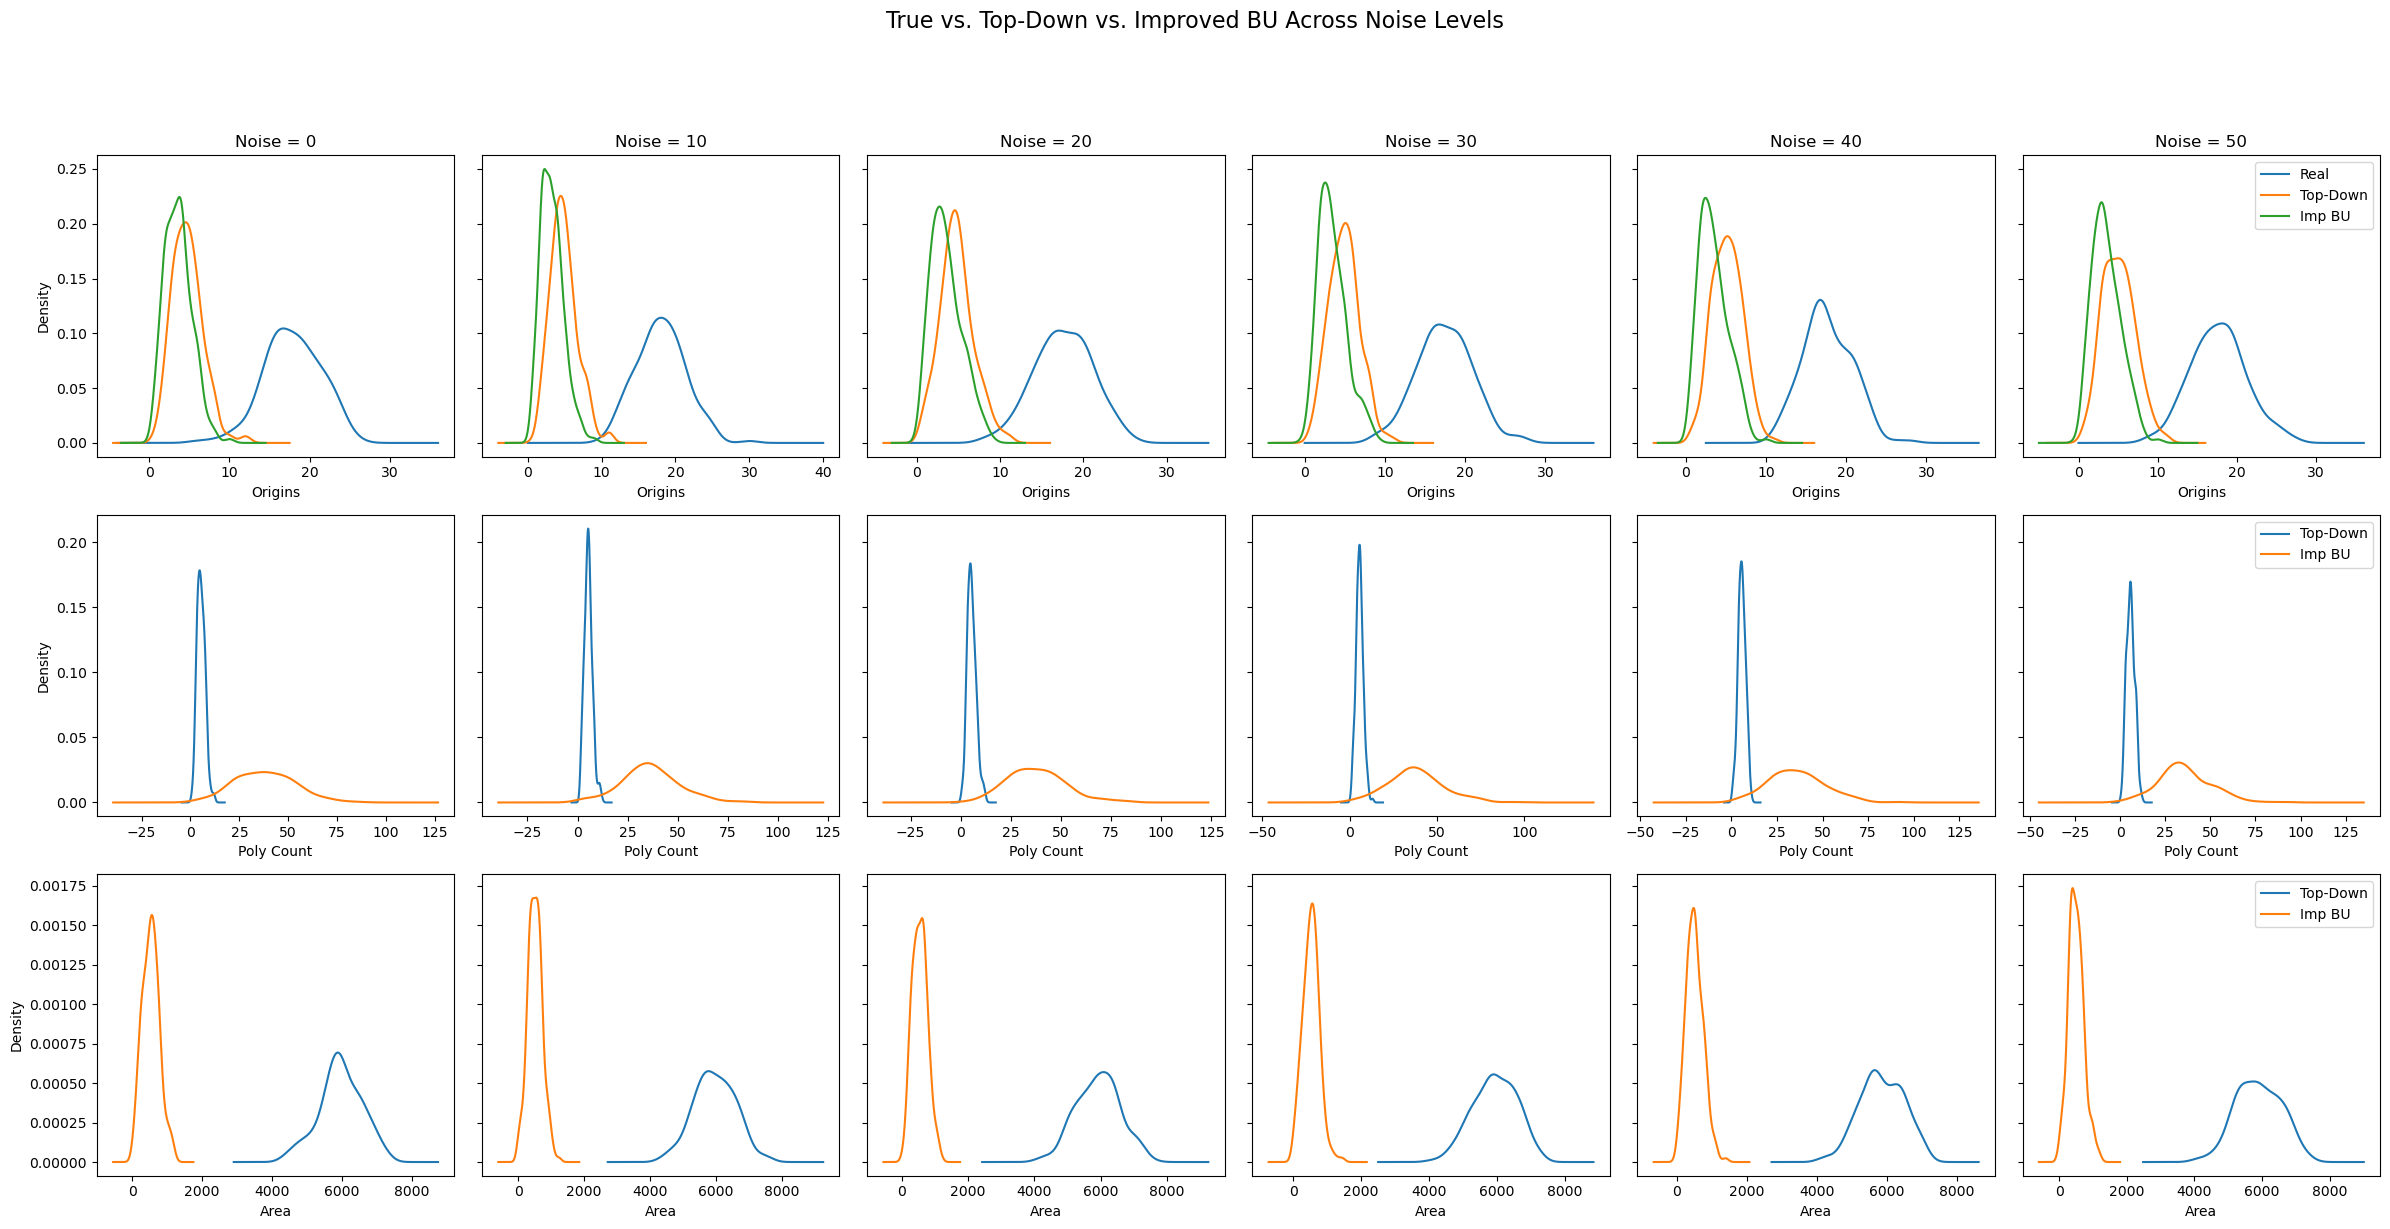

In [62]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from scipy.ndimage import label

# ─── 1) FIRE SIMULATION WITH GROUND‑TRUTH ORIGINS ───────────────────────────────

def simulate_burn_day_with_origins(rows, cols, days,
                                   wind_bias=(1,1),
                                   wind_strength=1.0,
                                   max_jump_distance=20):
    """
    Simulate burn‐day grid and count true origins:
      – initial ignition = 1 origin
      – each spot‐fire jump adds +1 origin
    Returns burn_day array and origin_count.
    """
    directions = [(-1,0),(1,0),(0,-1),(0,1),
                  (-1,-1),(-1,1),(1,-1),(1,1)]
    burn_day = np.full((rows, cols), -1, dtype=int)
    burned   = np.zeros((rows, cols), bool)

    # ignite center
    center = (rows//2, cols//2)
    burned[center]   = True
    burn_day[center] = 0
    origin_count = 1

    for day in range(1, days):
        new = set()
        front = np.argwhere(burned)

        # neighbor spread
        for r, c in front:
            for dr, dc in directions:
                nr, nc = r+dr, c+dc
                if 0 <= nr < rows and 0 <= nc < cols and not burned[nr, nc]:
                    p = 0.05
                    if (dr, dc) == wind_bias:
                        p += wind_strength
                    elif (np.sign(dr), np.sign(dc)) == wind_bias:
                        p += wind_strength/2
                    if random.random() < p:
                        new.add((nr, nc))

        # spotting jumps → count as new origin
        if random.random() < 0.3 and front.size > 0:
            cand = np.argwhere(~burned)
            if cand.size > 0:
                samp = cand[np.random.choice(len(cand),
                                             min(1000, len(cand)),
                                             replace=False)]
                dists  = np.linalg.norm(samp - center, axis=1)
                extent = np.max(np.linalg.norm(front - center, axis=1))
                close  = samp[dists < extent]
                if close.size > 0:
                    nr, nc = tuple(close[random.randrange(len(close))])
                    new.add((nr, nc))
                    origin_count += 1

        # apply burns
        for (r, c) in new:
            burned[r, c]   = True
            burn_day[r, c] = day

    return burn_day, origin_count

# ─── 2) CLUSTER FILTER ──────────────────────────────────────────────────────────

def filter_small_clusters(mask, min_size):
    """
    Remove connected clusters smaller than min_size.
    """
    lbl, n = label(mask)
    out = np.zeros_like(mask)
    for comp in range(1, n+1):
        comp_mask = (lbl == comp)
        if comp_mask.sum() >= min_size:
            out[comp_mask] = True
    return out

# ─── 3) POLYGON EXTRACTION & METRIC FUNCTIONS ──────────────────────────────────

def extract_polygons_from_mask(mask):
    """
    Given a boolean mask, contour at 0.5 and return a list of valid Polygons.
    """
    rows = mask.shape[0]
    polys = []
    for contour in measure.find_contours(mask.astype(float), 0.5):
        if contour.shape[0] < 4:
            continue
        coords = [(p[1], rows - p[0]) for p in contour]
        poly = Polygon(coords)
        if poly.is_valid and poly.area > 1:
            polys.append(poly)
    return polys

def fit_polygons_top_down_full(bd):
    """
    Top‑Down inference: contour final mask only.
    Returns (origins, poly_count, area).
    """
    final = (bd >= 0)
    polys = extract_polygons_from_mask(final)
    poly_count = len(polys)
    if poly_count == 0:
        return 0, 0, 0.0
    unioned = unary_union(polys)
    if isinstance(unioned, Polygon):
        origins = 1
        area    = unioned.area
    else:
        origins = len(unioned.geoms)
        area    = sum(p.area for p in unioned.geoms)
    return origins, poly_count, area

def fit_polygons_bottom_up_improved(bd,
                                   noise_per_day=50,
                                   min_cluster_size=10):
    """
    Bottom‑Up with cluster filtering:
      – inject noise_per_day random pixels each day
      – remove clusters smaller than min_cluster_size
      – contour each day
    Returns (origins, poly_count, area).
    """
    rows, cols = bd.shape
    all_polys = []
    for d in range(bd.max() + 1):
        m = (bd == d).copy()
        # inject noise
        coords = np.unravel_index(
            np.random.choice(rows*cols, noise_per_day, replace=False),
            (rows, cols)
        )
        m[coords] = True
        # filter small clusters
        m = filter_small_clusters(m, min_cluster_size)
        all_polys.extend(extract_polygons_from_mask(m))

    poly_count = len(all_polys)
    if poly_count == 0:
        return 0, 0, 0.0
    unioned = unary_union(all_polys)
    if isinstance(unioned, Polygon):
        origins = 1
        area    = unioned.area
    else:
        origins = len(unioned.geoms)
        area    = sum(p.area for p in unioned.geoms)
    return origins, poly_count, area

# ─── 4) PANEL ACROSS NOISE LEVELS WITH PNG & CSV OUTPUT ────────────────────────

def panel_across_noise_all_methods(
    rows=256, cols=256, days=60,
    wind_strength=1.0, max_jump_distance=10,
    noise_levels=[0,10,20,30,40,50],
    min_cluster_size=10,
    replicates=200,
    out_png="noise_panel.png",
    out_csv="noise_metrics.csv"
):
    methods = ["Real", "Top-Down", "Imp BU"]
    records = []

    fig, axes = plt.subplots(3, len(noise_levels),
                             figsize=(4*len(noise_levels), 12),
                             sharey='row')

    for col, n in enumerate(noise_levels):
        for _ in range(replicates):
            # simulate with true origin count
            bd, real_orig = simulate_burn_day_with_origins(
                rows, cols, days,
                wind_bias=(1,1),
                wind_strength=wind_strength,
                max_jump_distance=max_jump_distance
            )
            # infer via top-down
            td_orig, td_pc, td_area = fit_polygons_top_down_full(bd)
            # infer via improved bottom-up
            bu_orig, bu_pc, bu_area = fit_polygons_bottom_up_improved(
                bd,
                noise_per_day=n,
                min_cluster_size=min_cluster_size
            )

            records += [
                {"noise": n, "method": "Real",      "origins": real_orig, "poly_count": np.nan,   "area": np.nan},
                {"noise": n, "method": "Top-Down",  "origins": td_orig,   "poly_count": td_pc,     "area": td_area},
                {"noise": n, "method": "Imp BU",    "origins": bu_orig,   "poly_count": bu_pc,     "area": bu_area},
            ]

        df_col = pd.DataFrame(records)
        for row, metric in enumerate(["origins", "poly_count", "area"]):
            ax = axes[row, col]
            for m in methods:
                vals = df_col[(df_col["noise"]==n) & (df_col["method"]==m)][metric].dropna()
                if len(vals) > 1:
                    vals.plot.kde(ax=ax, label=m)
            if row == 0:
                ax.set_title(f"Noise = {n}")
            if col == 0:
                ax.set_ylabel("Density")
            ax.set_xlabel(metric.replace("_"," ").title())
            if col == len(noise_levels) - 1:
                ax.legend()

    plt.suptitle(
        "True vs. Top-Down vs. Improved BU Across Noise Levels",
        y=1.02, fontsize=16
    )
    plt.tight_layout(rect=[0,0,1,0.96])

    # save outputs
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    print(f"Panel saved to {out_png}")
    pd.DataFrame(records).to_csv(out_csv, index=False)
    print(f"Metrics saved to {out_csv}")

    plt.show()

if __name__ == "__main__":
    panel_across_noise_all_methods()
